### **1. Introduction & Goals**

**Context: From Pets to Plant Seedlings**

In the previous project (Oxford-IIIT Pets), we built and trained **custom CNNs** from scratch to classify 37 dog and cat breeds.  
That work gave us a deep understanding of:

- **Convolutional operations** (filters, pooling, feature hierarchies).  
- **Parameter efficiency** and how CNNs outperform MLPs for images.  
- The **limitations of shallow architectures** (e.g., 2–3 conv layers) on complex datasets.

**New Challenge: Plant Seedlings Classification**

We now shift domains — from pets to **agricultural plant species** — using the **Plant Seedlings dataset**:

- **12 plant species** (e.g., Maize, Sugar beet, Black-grass).
- **~4,275 RGB images** with varied **lighting, backgrounds, and plant stages**.
- Key challenges:
  - **Intra-class variation** (same plant looks different at different growth stages).
  - **Background noise** (soil, weeds, overlapping plants).
  - **Class imbalance** (some species are underrepresented).

**Why This Dataset?**

- Represents **real-world agricultural tasks** (crop monitoring, weed detection).
- Prepares us to handle **messier datasets** than clean academic ones (like Pets).
- Perfect starting point to explore **transfer learning** with pretrained models.

**Goals of This Notebook (NB01)**

1. **Load and explore the Plant Seedlings dataset** (images + labels).  
2. Apply **image preprocessing** (resize to 224×224, normalize to ImageNet stats).  
3. Visualize **class balance** and **sample images** (identify imbalance early).  
4. Recap **CNN fundamentals** from Project 5 to prepare for **transfer learning** in later notebooks.

**What’s Next (Upcoming Notebooks)**

- **NB02**: Transfer learning with pretrained models (feature extraction vs fine-tuning).  
- **NB03**: Data augmentation and hyperparameter tuning.  
- **NB04**: Model evaluation, error analysis, and generalization strategies.

---

### **2. Dataset Overview & Loading**

**About the Plant Seedlings Dataset**

- **Source:** Aarhus University Signal Processing Group + University of Southern Denmark  
- **Classes (12 plant species):**
  - Black-grass, Charlock, Cleavers, Common Chickweed, Common Wheat, Fat Hen,
    Loose Silky-bent, Maize, Scentless Mayweed, Shepherd’s Purse, Small-flowered Cranesbill, Sugar beet
- **Size:** ~4,275 labeled RGB images
- **Characteristics:**
  - Captured under **natural conditions** — with visible soil, varying lighting, and other background clutter.
  - **High intra-class variation:** the same species may look different across growth stages.
  - **Inter-class similarity:** early-stage seedlings can look visually similar across species.

This makes classification **harder** than the Oxford-IIIT Pets dataset used in Project 5, which had cleaner images and more distinct classes.

**Why Resize to 224×224 Pixels?**

In Project 5, we resized images to **128×128** for our *custom CNN* models.  
Here in Project 6, we aim to use **transfer learning with pretrained models** like ResNet or AlexNet. These models were originally trained on **ImageNet**, a massive dataset of 1.2M images across 1,000 classes (dogs, cats, cars, plants, etc.).

- **ImageNet models expect 224×224 input** — this is the standard resolution used during their training.
- By resizing seedlings images to 224×224, we **match the expected input size**, allowing us to reuse pretrained weights effectively.
- 224×224 is also a **good balance**: detailed enough to capture plant structures, but not too large to slow down CPU-based training.

**Why Use ImageNet Normalization (Mean/Std)?**

- Pretrained CNNs not only expect 224×224 input, but also **specific pixel statistics**:  
  - **Mean:** `[0.485, 0.456, 0.406]`  
  - **Standard Deviation:** `[0.229, 0.224, 0.225]`
- These values are computed from the **entire ImageNet dataset** and represent the typical RGB distribution across millions of natural images.

**Why normalize?**
- Ensures input images are **centered** (mean 0) and **scaled** (std ~1).
- Matches the distribution that pretrained weights were optimized on — crucial for transfer learning to work well.
- Without this, the pretrained features would misinterpret brightness/contrast and hurt performance.

Ref: <br>
https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670<br>
https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2<br>
https://discuss.pytorch.org/t/normalizing-with-imagenet-mean-and-std-vs-normalizing-with-my-own-datasets-mean-and-std/94953<br>


**Visualization Goals**

- Display a **grid of sample images** (one per class) to familiarize ourselves with the data.  
- Plot a **class distribution chart** to identify imbalance (e.g., Loose Silky-bent vs. Common wheat).  
- This helps anticipate challenges (e.g., some species may dominate the dataset and bias the model).

**Key Shift from Project 5 → Project 6**

- **Project 5:** Pets dataset, 128×128, custom CNN (trained from scratch).  
- **Project 6:** Seedlings dataset, 224×224, transfer learning (pretrained ImageNet CNNs).  
- **Why shift?** Leveraging pretrained networks can drastically reduce training time and improve accuracy, especially when data is limited or noisy.


**One-Time Preprocessing (Build Train/Test Split in NB01)**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Paths
# -----------------------------
# Path to extracted dataset (V2) downloaded (12 class folders directly here) from the site https://vision.eng.au.dk/plant-seedlings-dataset/
# raw_data_dir = "./plant-seedlings-raw"  
raw_data_dir = r"C:\Users\noman\.cache\kagglehub\datasets\vbookshelf\v2-plant-seedlings-dataset\versions\1"

# Target folder where split data will be stored
split_data_dir = "./data/plant-seedlings"

train_dir = os.path.join(split_data_dir, "train")
test_dir  = os.path.join(split_data_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# -----------------------------
# 2. Split Logic
# -----------------------------
for class_name in os.listdir(raw_data_dir):
    class_path = os.path.join(raw_data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # All images for this class
    images = [
        os.path.join(class_path, f)
        for f in os.listdir(class_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    # 80-20 train/test split
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create class subfolders in train/test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy images to respective folders
    for img in train_imgs:
        shutil.copy(img, os.path.join(train_dir, class_name))
    for img in test_imgs:
        shutil.copy(img, os.path.join(test_dir, class_name))

print(f"Train/Test split created at: {split_data_dir}")

Train/Test split created at: ./data/plant-seedlings


**Checking the downloaded dataset structure**

In [ ]:
for class_name in os.listdir(raw_data_dir):
    class_path = os.path.join(raw_data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    print(f"{class_name}: {len(images)} images")

Black-grass: 309 images
Charlock: 452 images
Cleavers: 335 images
Common Chickweed: 713 images
Common wheat: 253 images
Fat Hen: 538 images
Loose Silky-bent: 762 images
Maize: 257 images
Scentless Mayweed: 607 images
ShepherdΓÇÖs Purse: 274 images
Small-flowered Cranesbill: 576 images
Sugar beet: 463 images


**Loading the Train and Test data**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------
# 1. Path to split dataset
# -----------------------------
data_path = "./data/plant-seedlings"

train_dir = os.path.join(data_path, "train")
test_dir  = os.path.join(data_path, "test")

# -----------------------------
# 2. Transformations
# -----------------------------
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# -----------------------------
# 3. Load datasets
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 4. Verify
# -----------------------------
print(f"Classes: {train_dataset.classes}")
print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")


Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdΓÇÖs Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Train samples: 4426 | Test samples: 1113


**Visualize Sample Images**

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

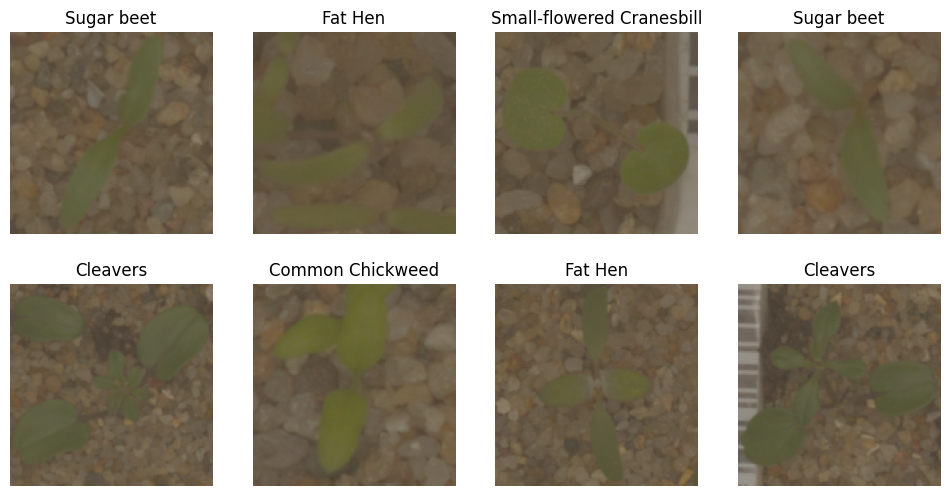

In [20]:
# ---------------------------------------------------------
# Display images after reversing normalization
# ---------------------------------------------------------
# Why do we "unnormalize" here?
# - During preprocessing, images were normalized to ImageNet mean/std
#   so model training works correctly (centered data, stable gradients).
# - For visualization, we must reverse this step to recover the original
#   color range (0–1) so the images look natural.
# ---------------------------------------------------------

def imshow(inp, title=None):
    """Display a tensor image after unnormalizing (ImageNet stats)."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Show first 8 training images
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    imshow(images[i], title=train_dataset.classes[labels[i]])
plt.show()


**Class Balance Visualization**

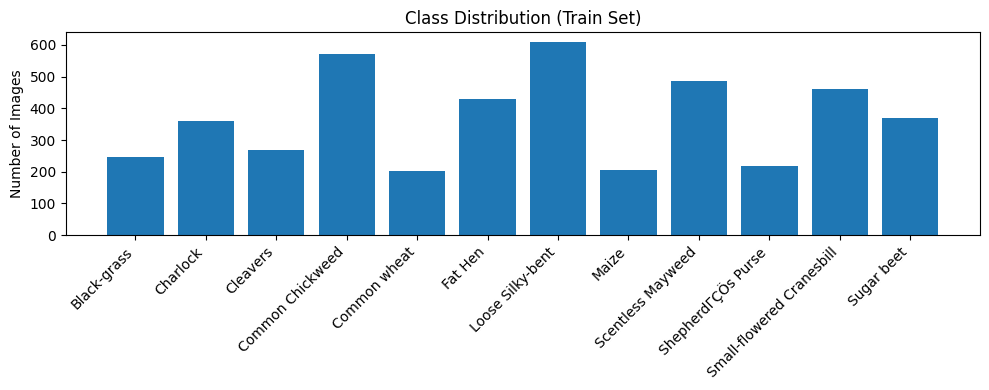

In [19]:
import collections

# Count samples per class
class_counts = collections.Counter([label for _, label in train_dataset.samples])

# Convert to list aligned with class_names
counts = [class_counts[i] for i in range(len(train_dataset.classes))]

# Plot
plt.figure(figsize=(10, 4))
plt.bar(train_dataset.classes, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution (Train Set)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


**Reflection**

- The **Plant Seedlings dataset** introduces greater **visual complexity** than the Oxford Pets dataset:
  - Background clutter (soil, grass) and similar early-stage appearances across species.
  - Pronounced **class imbalance** (e.g., Loose Silky-bent vs Common wheat).

- By standardizing inputs to **224×224** and using **ImageNet mean/std normalization**, we align with **pretrained CNNs** (ResNet, AlexNet) that we’ll leverage in the next notebooks.

- This step bridges **custom CNN training (Project 5)** and **transfer learning (Project 6)** — preparing us to exploit deeper, pretrained features.

> **Note**: We will create a dedicated validation split later (in Section 4) for model tuning and monitoring.

---

### **3. Quick CNN Recap (from Project 5)**

Before we dive into **transfer learning**, let’s briefly revisit what we learned about CNNs in **Project 5 (Oxford-IIIT Pets)**.

**What is the CNN pipeline?**

A **Convolutional Neural Network (CNN)** transforms raw image pixels into class probabilities through a structured hierarchy:

1. **Convolution Layers**  
   - Apply filters (kernels) to detect **local features** (edges, corners).  
2. **Pooling Layers**  
   - Downsample feature maps to reduce spatial size and enforce **translation invariance**.  
3. **Flatten**  
   - Convert 2D feature maps into a 1D vector for dense layers.  
4. **Fully Connected Layers (FC)**  
   - Combine features for **class-level reasoning**.  
5. **Softmax**  
   - Produce probabilities across all classes.

**Baseline CNN (Project 5)**

Here’s a schematic of the **2-conv + 2-FC** model we built for pet breed classification:

```text
Input (3 × 128 × 128)
        │
[Conv2D 3→16, 3×3] → ReLU → MaxPool(2×2)
        │
[Conv2D 16→32, 3×3] → ReLU → MaxPool(2×2)
        │
Flatten (32 × 32 × 32)
        │
[FC: 32×32×32 → 128] → ReLU
        │
[FC: 128 → 37] → Softmax

```
**Key Takeaways from Project 5**

- **Parameter efficiency:**  
  CNNs re-use filters (weight sharing), unlike MLPs where each pixel connects independently.  
- **Feature hierarchy:**  
  - Early layers detect edges & colors.  
  - Deeper layers detect textures, shapes, and eventually object parts.  
- **Challenges observed:**  
  - Shallow CNN struggled with complex breed variations.  
  - Overfitting without augmentation or regularization.

**Why Transfer Learning Now?**

Instead of **training CNNs from scratch** on every dataset:
- We can use **pretrained networks** (e.g., ResNet, AlexNet) trained on **ImageNet (1.2M images, 1000 classes)**.
- These models already **learned general visual features** (edges, shapes, textures) that transfer well to new tasks.
- We only need to **fine-tune or replace the final layers** for our target classes (12 plant species).

This shift is crucial for **Project 6 (Plant Seedlings)**:
- Smaller dataset (~4k images) benefits from pretrained features.
- Faster convergence and better accuracy with limited data.

**Next:**  
We load **pretrained architectures** (ResNet/AlexNet) and adapt them for **12-class plant classification**.

---

### **4. Preparing for Training**

**Why a Validation Set?**

- The **test set** is reserved for final evaluation (to simulate unseen data).
- We need a **validation set** during training to:
  - Monitor **overfitting** (gap between train vs. val performance).
  - Tune **hyperparameters** (e.g., learning rate, model depth).
  - Select the **best checkpoint** before touching the test set.


**Strategy**

1. Start from the **80/20 train/test split** we prepared earlier (Section 2).
2. From the `train/` folder, move **15% of images** (per class) into a new `val/` folder.
3. This yields:
   - Train ≈ 68% of total data
   - Val ≈ 12% of total data
   - Test = 20% of total data


**Key Differences (Project 5 vs Project 6)**

| Aspect              | Project 5 (Pets)     | Project 6 (Seedlings)         |
|---------------------|---------------------|-------------------------------|
| Image Size          | 128×128             | 224×224                       |
| Architecture        | Custom CNN (scratch)| Pretrained CNN (transfer)     |
| Domain              | Cats & Dogs         | Plant species (agriculture)   |
| Challenges          | Breed similarity    | Growth stages, soil background|
| Dataset Size        | ~7k images          | ~4k images                     |

This notebook prepares us for **NB02**, where we’ll train a custom CNN on this dataset before moving to transfer learning.

In [21]:
import os
import shutil
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Paths
# -----------------------------
data_path = "./data/plant-seedlings"
train_dir = os.path.join(data_path, "train")
val_dir   = os.path.join(data_path, "val")

os.makedirs(val_dir, exist_ok=True)

# -----------------------------
# 2. Create validation split (15% of train)
# -----------------------------
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # All images in this class
    images = [
        os.path.join(class_path, f)
        for f in os.listdir(class_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    # Skip if validation already exists for this class
    val_class_path = os.path.join(val_dir, class_name)
    if not os.path.exists(val_class_path):
        os.makedirs(val_class_path, exist_ok=True)

    # 15% split for validation
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    # Move validation images
    for img in val_imgs:
        dest_path = os.path.join(val_class_path, os.path.basename(img))
        shutil.move(img, dest_path)

print(f"Validation split created at: {val_dir}")

# -----------------------------
# 3. Load datasets (train/val/test)
# -----------------------------
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Paths for train, val, test
test_dir = os.path.join(data_path, "test")

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 4. Verify splits
# -----------------------------
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")


Validation split created at: ./data/plant-seedlings\val
Train samples: 3756
Val samples: 670
Test samples: 1113
Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdΓÇÖs Purse', 'Small-flowered Cranesbill', 'Sugar beet']


---

### **5. Next Steps**

**What we accomplished in this notebook:**

- Introduced the **Plant Seedlings dataset** and its real-world agricultural challenges.
- Standardized images to **224×224** and normalized using **ImageNet statistics**.
- Explored dataset composition:
  - Class names and visual examples.
  - Imbalance across classes (important for training strategies).
- Created a clean **train/val/test split**:
  - Train: 68% (model fitting)
  - Val: 12% (hyperparameter tuning & early stopping)
  - Test: 20% (final evaluation)

- Recapped **CNN fundamentals** from Project 5 to prepare for deeper architectures.


**What’s coming in NB02:**

- Build and train a **custom CNN (LeNet-style)** from scratch on the seedlings dataset.
- Evaluate its **accuracy and per-class performance**.
- Identify **limitations of scratch models**, motivating **transfer learning** in NB03.


**Big Picture:**

This notebook bridges our earlier work (Pets dataset, 128×128 images, custom CNNs) with the more advanced world of **pretrained networks and agricultural applications**.  
By the end of Project 6, we’ll have compared **scratch vs. transfer learning** approaches and discussed their trade-offs for real-world use.
